In [1]:
import numpy as np
import tensorflow as tf
from keras import backend as K

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model, Model
from keras.layers import concatenate, Activation, GlobalAveragePooling1D, GlobalMaxPooling1D, Layer, Dense, Embedding, LSTM, GRU, Dropout, SpatialDropout1D, Input, Average, Bidirectional, BatchNormalization
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers

from keras.models import load_model
import json, argparse, os
import re
import io
import sys

Using TensorFlow backend.


In [2]:
# Don't hog GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

In [3]:
# Path to training and testing data file. This data can be downloaded from a link, details of which will be provided.
trainDataPath = "./train.txt"
testDataPath = "./dev.txt"
# Output file that will be generated. This file can be directly submitted.
solutionPath = "./test.txt"
# Path to directory where GloVe file is saved.
gloveDir = ""

In [244]:
NUM_CLASSES = 4                 # Number of classes - Happy, Sad, Angry, Others
MAX_NB_WORDS = 7500                # To set the upper limit on the number of tokens extracted using keras.preprocessing.text.Tokenizer 
MAX_SEQUENCE_LENGTH = 30         # All sentences having lesser number of words than this will be padded
EMBEDDING_DIM = 300               # The dimension of the word embeddings

In [5]:
label2emotion = {0:"others", 1:"happy", 2: "sad", 3:"angry"}
emotion2label = {"others":0, "happy":1, "sad":2, "angry":3}

In [253]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def cleanText(text, remEmojis=True, meta=True, abbrfix=True):
    if abbrfix:
        text = re.sub(r"\b[u]+\b", "you", text)
        text = re.sub(r"\bm\b", "am", text)
        text = re.sub(r"\bn\b", "and", text)
        text = re.sub(r"\bluv\b", "love", text)
        text = re.sub(r"\bans\b", "answer", text)
        text = re.sub(r"\bwt\b", "what", text)
        text = re.sub(r"\br\b", "are", text)
        text = re.sub(r"\bur\b", "your", text)
        text = re.sub(r"\bnthng\b", "nothing", text)
        text = re.sub(r"\btxt\b", "text", text)
        text = re.sub(r"\bconvo\b", "conversation", text)
        text = re.sub(r"\bdont\b", "do not", text)
        text = re.sub(r"\bim\b", "i am", text)
        text = re.sub(r"\bi m\b", "i am", text)
        text = re.sub(r"\bwlcm\b", "welcome", text)
        text = re.sub(r"\bdnt\b", "did not", text)
        text = re.sub(r"\bknw\b", "know", text)
        text = re.sub(r"\bsry\b", "sorry", text)
        text = re.sub(r"\bchating\b", "chatting", text)
        text = re.sub(r"\bfrnds\b", "friends", text)
        text = re.sub(r"\bsrry\b", "sorry", text)
        text = re.sub(r"\burself\b", "yourself", text)
        text = re.sub(r"&amp;", "and", text)
        text = re.sub(r"&apos;", "", text)
        text = re.sub(r"\btal\b", "talk", text)
        text = re.sub(r"\bsec\b", "second", text)
        text = re.sub(r"\bmin\b", "minute", text)
        text = re.sub(r"\bfr\b", "for", text)
        text = re.sub(r"\bwrk\b", "work", text)
        text = re.sub(r"\bfrm\b", "from", text)
        text = re.sub(r"\bwr are\b", "where are", text)
        text = re.sub(r"\bwrkng\b", "working", text)
        text = re.sub(r"\bmyslf\b", "myself", text)
        text = re.sub(r"\bbtr\b", "better", text)
        text = re.sub(r"\bdon't\b", "do not", text)
        text = re.sub(r"\bdon’t\b", "do not", text)
        text = re.sub(r"\bi'm\b", "i am", text)
        text = re.sub(r"\bit's\b", "it is", text)
        text = re.sub(r"\byou're\b", "you are", text)
        text = re.sub(r"\byou’re\b", "you are", text)
        text = re.sub(r"\bthat's\b", "that is", text)
        text = re.sub(r"\bcan't\b", "cannot", text)
        text = re.sub(r"\bcan’t\b", "cannot", text)
        text = re.sub(r"\bwhat's\b", "what is", text)
        text = re.sub(r"\bwhat’s\b", "what is", text)
        text = re.sub(r"\bdidn't\b", "did not", text)
        text = re.sub(r"\bi'll\b", "i will", text)
        text = re.sub(r"\blet's\b", "let us", text)
        text = re.sub(r"\bi've\b", "i have", text)
        text = re.sub(r"\bwon't\b", "will not", text)
        text = re.sub(r"\bdoesn't\b", "does not", text)
        text = re.sub(r"\bit'll\b", "it will", text)
        text = re.sub(r"\bofcourse\b", "of course", text)
        text = re.sub(r"\bbc[u]?z\b", "because", text)
        text = re.sub(r"\bwe'll\b", "we will", text)
        text = re.sub(r"\bwhen's\b", "when is", text)
        text = re.sub(r"\bwe've\b", "we have", text)
        text = re.sub(r"\bhe's\b", "he is", text)
        text = re.sub(r"\bshe's\b", "she is", text)
        text = re.sub(r"\bfrnd\b", "friend", text)
        text = re.sub(r"\bi’m\b", "i am", text)
        text = re.sub(r"\bthnks\b", "thanks", text)
        text = re.sub(r"\bi’am\b", "i am", text)
        text = re.sub(r"\bisn't\b", "is not", text)
        text = re.sub(r"\bhaven't\b", "have not", text)
        text = re.sub(r"\bhow's\b", "how is", text)
        text = re.sub(r"\bhow're\b", "how are", text)
        text = re.sub(r"\bhowz\b", "how is", text)
        text = re.sub(r"\bwasn't\b", "was not", text)
        text = re.sub(r"\bthere's\b", "there is", text)
        text = re.sub(r"\bwe're\b", "we are", text)
        text = re.sub(r"\byou'll\b", "you will", text)
        text = re.sub(r"\bcouldn't\b", "could not", text)
        text = re.sub(r"\bthey're\b", "they are", text)
        text = re.sub(r"\bit’s\b", "it is", text)
        text = re.sub(r"\bthat’s\b", "that is", text)
        text = re.sub(r"\bain't\b", "is not", text)
        text = re.sub(r"\bwho's\b", "who is", text)
        text = re.sub(r"\byou've\b", "you have", text)
        text = re.sub(r"\bwhere's\b", "where is", text)
        text = re.sub(r"\bshouldn't\b", "should not", text)
        text = re.sub(r"\bwouldn't\b", "would not", text)
        text = re.sub(r"\b'you\b", "you", text)
        text = re.sub(r"\bit'd\b", "it would", text)
        text = re.sub(r"\bidk\b", "i do not know", text)
        text = re.sub(r"\brofl\b", "haha", text)
        text = re.sub(r"\blmao\b", "haha", text)
        text = re.sub(r"\bweren't\b", "were not", text)
        text = re.sub(r"\bone's\b", "one is", text)
        text = re.sub(r"\bwhay\b", "what", text)
        text = re.sub(r"\bsomthing\b", "something", text)
        text = re.sub(r"\bhow've\b", "how have", text)
        text = re.sub(r"\bhurted\b", "hurt", text)
        text = re.sub(r"\bshutup\b", "shut up", text)
        text = re.sub(r"\bwhatsup\b", "what is up", text)
        text = re.sub(r"\bintrested\b", "interested", text)
        text = re.sub(r"\btbh\b", "to be honest", text)
        text = re.sub(r"\btmrw\b", "tomorrow", text)
        text = re.sub(r"\bopps\b", "oops", text)
        text = re.sub(r"\balrighty\b", "alright", text)
        text = re.sub(r"\bdumbass\b", "dumb ass", text)
        text = re.sub(r"\bfrds\b", "friends", text)
        text = re.sub(r"\bcomeon\b", "come on", text)
        text = re.sub(r"\bhogaya\b", "done", text)
        text = re.sub(r"\bfrst\b", "first", text)
        text = re.sub(r"\bmsgs\b", "messages", text)
        text = re.sub(r"\bttyl\b", "talk to you later", text)
        text = re.sub(r"\bthts\b", "that is", text)
        text = re.sub(r"\bikr\b", "i know right ?", text)
        text = re.sub(r"\bthanku\b", "thank you", text)
        text = re.sub(r"\b'you\b", "you", text)
        text = re.sub(r"\bwhts\b", "what is", text)
        text = re.sub(r"\byou'are\b", "you are", text)
        text = re.sub(r"\bypu\b", "you", text)
        text = re.sub(r"\bryt\b", "right", text)
        text = re.sub(r"\banytym\b", "anytime", text)
        text = re.sub(r"\bbitch(.*)\b", "bitch", text)
        text = re.sub(r"\blyk\b", "like", text)
        text = re.sub(r"\bgf\b", "girlfriend", text)
        text = re.sub(r"\bbf\b", "boyfriend", text)
        text = re.sub(r"\bnopes\b", "nope", text)
        text = re.sub(r"\behat\b", "what", text)
        text = re.sub(r"\babt\b", "about", text)
        text = re.sub(r"\bhppnd\b", "happened", text)
        text = re.sub(r"\bbtwn\b", "between", text)
        text = re.sub(r"\bsended\b", "sent", text)
        text = re.sub(r"\bmrng\b", "morning", text)
        text = re.sub(r"\biwant\b", "I want", text)
        text = re.sub(r"\bprblm\b", "problem", text)
        text = re.sub(r"\btomorow\b", "tomorrow", text)
        text = re.sub(r"\bahaha\b", "haha", text)
        text = re.sub(r"\bo[h]+[k]+\b", "okay", text)
        text = re.sub(r"\byour's\b", "yours", text)
        text = re.sub(r"\bnvm\b", "never mind", text)
        text = re.sub(r"\btlk\b", "talk", text)
        text = re.sub(r"\b'you\b", "you", text)
        text = re.sub(r"\bbbey\b", "baby", text)
        text = re.sub(r"\bgril\b", "grill", text)
        text = re.sub(r"\broboy\b", "robot", text)
        text = re.sub(r"\b[']?i\b", "I", text)
        text = re.sub(r"\bintrest\b", "interest", text)
        text = re.sub(r"\blonley\b", "lonely", text)
        text = re.sub(r"\b-\b", "", text)
        text = re.sub(r"\babt\b", "about", text)
        text = re.sub(r"\bbday\b", "birthday", text)
        text = re.sub(r"\bohkay\b", "okay", text)
        text = re.sub(r"\bne\b", "me", text)
        text = re.sub(r"\bwat\b", "what", text)
        text = re.sub(r"\bwatever\b", "whatever", text)
        text = re.sub(r"\brply\b", "reply", text)
        text = re.sub(r"\btnx\b", "thanks", text)
        text = re.sub(r"\bawsm\b", "awesome", text)
        text = re.sub(r"\bcr[a]+[z]+y\b", "crazy", text)
        text = re.sub(r"\bdidnt\b", "did not", text)
        text = re.sub(r"\bdonot\b", "do not", text)
        text = re.sub(r"\bbestfriend\b", "best friend", text)
        text = re.sub(r"\bsmthing\b", "something", text)
        text = re.sub(r"\bw[a]+[t]+\b", "what", text)
        text = re.sub(r"\bwh[a]+t\b", "what", text)
        text = re.sub(r"\b[y]+[a]+[y]+\b", "yay", text)
        text = re.sub(r"\ber[r]+\b", "err", text)
        text = re.sub(r"\btel[l]+\b", "tell", text)

    
    emojis = ['😂', '😭', '😞', '😢', '😁', '😅', '😍',
              '😀', '😃', '😡', '😄', '😆', '😒', '😊',
              '😌', '😠', '😤', '🙂', '😺', '😫', '😩',
              '😹', '😜', '👍', '😘', '😸', '😉', '😽',
              '😻', '😏', '💔', '😝', '😑', '🙁', '😾',
              '😿', '😬', '❤', '😋', '🙄', '😔', '🙀',
              '😎', '👎', '😦', '😧', '❤️', '😛', '😶',
              '😐', '👌', '🤔','😇', '😨', '😯', '😳',
              '☹️', '💋', '👋', '😪', '😥', '💕', '😱',
              '🙈', '😟', '🙏', '✌', '😖', '😣', '😮',
              '🤗', '😓', '😷', '☹', '💞', '🏻', '🙌',
              '💐', '🙊', '😰', '☺', '😴', '🖕', '♥', '😕',
              '😈', '👿','💗', '♡', '👀', '👊', '‑c', '🖑',
              ' 8‑d', ' ‑d', '👻', '：）', '.', '?', '!', ',',
              '-', '・', "'-'", '\U0001f923','・ω・', '\U000fe339', ' ‑c', '_']
    
    if remEmojis:
        for emoji in emojis:
            text = text.replace(emoji, "")
    
    if meta:
        text = re.sub(r"\b[y]+\b", "why", text)
        text = re.sub(r"\bpl[s]+\b", "please", text)
        text = re.sub(r"\bpl[z]+\b", "please", text)
        text = re.sub(r"\baren't\b", "are not", text)
        text = re.sub(r"\bb[e]?coz\b", "because", text)
        text = re.sub(r"\by[a]+r\b", "yaar", text)
        text = re.sub(r"\bth[a]?nx\b", "thanks", text)
        text = re.sub(r"\bye[s]+\b", "yes", text)
        text = re.sub(r"\b[o]+[k]+\b", "okay", text)
        text = re.sub(r"\bha[ha]+\b", "haha", text)
        text = re.sub(r"\bhe[he]+\b", "haha", text)
        text = re.sub(r"\bby[y]+\b", "bye", text)
        text = re.sub(r"\b[l]+[o]+[l]+\b", "haha", text)
        text = re.sub(r"\bum[m]+\b", "umm", text)
        text = re.sub(r"\bho[o]+\b", "who", text)
        text = re.sub(r"\bhe[y]+\b", "hey", text)
        text = re.sub(r"\bkn[o]+[w]+\b", "know", text)
        text = re.sub(r"\byu[p]+\b", "yup", text)
        text = re.sub(r"\bhref\b", "", text)
        text = re.sub(r"\byo[u]+\b", "you", text)
        text = re.sub(r"\bye[a]+[h]*\b", "yeah", text)
        text = re.sub(r"\byo[u]+\b", "you", text)
        text = re.sub(r"\bx‑d\b", "haha", text)
        text = re.sub(r"\bna[h]+\b", "nah", text)
        text = re.sub(r"\bto[o]+\b", "too", text)
        text = re.sub(r"\b'i\b", "i", text)
        text = re.sub(r"\b'you\b", "you", text)
        text = re.sub(r"\bnt[n]?g\b", "nothing", text)
        text = re.sub(r"\bi\b", "I", text)
        text = re.sub(r"\b[m]+[e]+\b", "me", text)
        text = re.sub(r"\b[o]+[k]+[a]+[y]+\b", "okay", text)
        text = re.sub(r"\b[o]+[h]+\b", "oh", text)
        text = re.sub(r"\b[b]+[y]+[e]+\b", "bye", text)
        text = re.sub(r"\by[a]+\b", "ya", text)
        text = re.sub(r"\b[w]+[h]+[y]+\b", "why", text)
        text = re.sub(r"\b[w]+[o]+[w]+\b", "wow", text)
        text = re.sub(r"\b[a]+[w]+\b", "aww", text)
        text = re.sub(r"\b[h]+[m]+\b", "hmm", text)
        text = re.sub(r"\bwh[a]+\b", "what", text)
        text = re.sub(r"\bn[a]+[h]*\b", "no", text)
        text = re.sub(r"\bncr[a]+[z]+[y]+\b", "crazy", text)
        text = re.sub(r"\b[y]+[a]*[r]+\b", "friend", text)

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/paragag/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [254]:
def preprocessData(dataFilePath, mode):
    """Load data from a file, process and return indices, conversations and labels in separate lists
    Input:
        dataFilePath : Path to train/test file to be processed
        mode : "train" mode returns labels. "test" mode doesn't return labels.
    Output:
        indices : Unique conversation ID list
        conversations : List of 3 turn conversations, processed and each turn separated by the <eos> tag
        raw_conversations : All conversations together
        labels : [Only available in "train" mode] List of labels
    """
    indices = []
    conversations = []
    raw_conversations = []
    labels = []
    with io.open(dataFilePath, encoding="utf8") as finput:
        finput.readline()
        for line in finput:
            # Convert multiple instances of . ? ! , to single instance
            # okay...sure -> okay . sure
            # okay???sure -> okay ? sure
            # Add whitespace around such punctuation
            # okay!sure -> okay ! sure
            raw_conv = ' '.join(line[:].strip().split('\t')[1:4])
            repeatedChars = ['.', '?', '!', ',']
            for c in repeatedChars:
                lineSplit = line.split(c)
                while True:
                    try:
                        lineSplit.remove('')
                    except:
                        break
                cSpace = ' ' + c + ' '    
                line = cSpace.join(lineSplit)
            
            line = line.strip().split('\t')
            if mode == "train":
                # Train data contains id, 3 turns and label
                label = emotion2label[line[4]]
                labels.append(label)
            
            conv = ' <eos> '.join(line[1:4])
            
            # Remove any duplicate spaces
            duplicateSpacePattern = re.compile(r'\ +')
            conv = re.sub(duplicateSpacePattern, ' ', conv)
            
            indices.append(int(line[0]))
            processedData = cleanText(conv.lower())
            
            processedData = re.sub(r"\bi\b", "I", processedData)
            conversations.append(processedData)
            raw_conversations.append(raw_conv)
    
    if mode == "train":
        return indices, conversations, raw_conversations, labels
    else:
        return indices, conversations, raw_conversations

In [9]:
def getEmbeddingMatrix(wordIndex):
    """Populate an embedding matrix using a word-index. If the word "happy" has an index 19,
       the 19th row in the embedding matrix should contain the embedding vector for the word "happy".
    Input:
        wordIndex : A dictionary of (word : index) pairs, extracted using a tokeniser
    Output:
        embeddingMatrix : A matrix where every row has 100 dimensional GloVe embedding
    """
    embeddingsIndex = {}
    # Load the embedding vectors from ther GloVe file
    with io.open(os.path.join(gloveDir, 'glove.6B.%dd.txt' % EMBEDDING_DIM), encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            embeddingVector = np.asarray(values[1:], dtype='float32')
            embeddingsIndex[word] = embeddingVector
    
    print('Found %s word vectors.' % len(embeddingsIndex))
    
    oov = []
    # Minimum word index of any word is 1. 
    embeddingMatrix = np.zeros((len(wordIndex) + 1, EMBEDDING_DIM))
    count, total= 0, 0
    for word, i in wordIndex.items():
        embeddingVector = embeddingsIndex.get(word)
        total += 1
        if embeddingVector is not None:
            # words not found in embedding index will be all-zeros.
            embeddingMatrix[i] = embeddingVector
            count += 1
        else:
            oov.append(word)
    
    print("Found embedding for", str((100 * count) / total), "% embeddings")
    return embeddingMatrix, oov

In [10]:
def getGoogleEmbeddingMatrix(wordIndex):
    """Populate an embedding matrix using a word-index. If the word "happy" has an index 19,
       the 19th row in the embedding matrix should contain the embedding vector for the word "happy".
    Input:
        wordIndex : A dictionary of (word : index) pairs, extracted using a tokeniser
    Output:
        embeddingMatrix : A matrix where every row has 100 dimensional GloVe embedding
    """
    from gensim.models import KeyedVectors as kv
    embeddingsIndex = kv.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

    oov = []
    # Minimum word index of any word is 1. 
    embeddingMatrix = np.zeros((len(wordIndex) + 1, EMBEDDING_DIM))
    count, total= 0, 0
    for word, i in wordIndex.items():
        total += 1
        try:
            embeddingVector = embeddingsIndex[word]
            # words not found in embedding index will be all-zeros.
            embeddingMatrix[i] = embeddingVector
            count += 1
        except:
            oov.append(word)
    
    print("Found embedding for", str((100 * count) / total), "% embeddings")
    return embeddingMatrix, oov

In [ ]:
googleEmbeddingMatrix, googleOov = getGoogleEmbeddingMatrix(wordIndex)

In [255]:
print("Processing training data...")
trainIndices, trainTexts, rawtrainTexts, labels = preprocessData(trainDataPath, mode="train")
labels = to_categorical(np.asarray(labels), NUM_CLASSES)
print("Processing test data...")
testIndices, testTexts, rawtestTexts, testLabels = preprocessData(testDataPath, mode="train")
testLabels = to_categorical(np.asarray(testLabels), NUM_CLASSES)

print("Extracting tokens...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(trainTexts)
trainSequences = tokenizer.texts_to_sequences(trainTexts)
testSequences = tokenizer.texts_to_sequences(testTexts)

wordIndex = tokenizer.word_index
print("Found %s unique tokens." % len(wordIndex))

Processing training data...
Processing test data...
Extracting tokens...
Found 14670 unique tokens.


In [256]:
lens = [len(x) for x in trainSequences]
print("Coverage (cutoff length):", np.sum(np.array(lens) <= MAX_SEQUENCE_LENGTH) / len(trainSequences))

Coverage (cutoff length): 0.978945623342175


In [257]:
sorted_wordcounts = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)
words_covered, total_words = 0, 0
for i, tup in enumerate(sorted_wordcounts):
    total_words += tup[1]
    if i < MAX_NB_WORDS:
        words_covered += tup[1]
print("Coverage with %d words:" % MAX_NB_WORDS, words_covered/total_words)

Coverage with 7500 words: 0.9847698268390912


In [42]:
def split_into_three(texts, tknzr):
    middle, left, right = [], [], []
    for text in texts:
        l, m, r = text.split(' <eos> ')
        middle.append(m)
        left.append(l)
        right.append(r)
    tokenize = lambda x: tknzr.texts_to_sequences(x)
    return (tokenize(left), tokenize(middle), tokenize(right))

In [263]:
train_l, train_m, train_r = split_into_three(trainTexts, tokenizer)
test_l, test_m, test_r = split_into_three(testTexts, tokenizer)

train_all = tokenizer.texts_to_sequences(trainTexts)
test_all = tokenizer.texts_to_sequences(testTexts)

In [270]:
for i in range(5):
    print(trainTexts[i])
    print(rawtrainTexts[i])
    print()

do not worry I am girl <eos> hmm how do I know if you are <eos> what is your name  
do not worry  i am girl hmm how do I know if you are What's your name?

when did I  <eos> saw many times I think  <eos> no  I never saw you
When did I? saw many times i think -_- No. I never saw you

by <eos> by google chrome <eos> where you live
By by Google Chrome Where you live

you are ridiculous <eos> I might be ridiculous but I am telling the truth  <eos> you little disgusting whore
you are ridiculous I might be ridiculous but I am telling the truth. you little disgusting whore

just for time pass <eos> what do you do for a living then <eos> maybe
Just for time pass wt do you do for a living then Maybe



In [260]:
print("Populating embedding matrix...")
embeddingMatrix, oov = getEmbeddingMatrix(wordIndex)
oov = [(x, tokenizer.word_counts.get(x, 0)) for x in oov]

Populating embedding matrix...
Found 400000 word vectors.
Found embedding for 73.653715064758 % embeddings


In [261]:
oov.sort(key=lambda tup: tup[1], reverse=True)

In [262]:
print(oov[:120])

[("i'd", 82), ('‑', 54), ('️', 38), ('emoji', 31), ('‑d', 23), ("'i", 23), ("you'd", 21), ("'‑", 20), ('chatbot', 18), ('selfie', 17), ("'you", 16), ('i̇', 15), ("someone's", 11), ("valentine's", 10), ("friend's", 10), ('○', 9), ('️️', 9), ("life's", 8), ('emojis', 8), ("today's", 8), ('friendzone', 8), ('hmmzoning', 8), ('oho', 8), ('gng', 7), ("'o", 7), ('tajmahal', 7), ('i’ve', 7), ('‑3', 7), ('bangaram', 7), ('bestie', 6), ("people's", 6), ('ehh', 6), ('nthg', 6), ("here's", 6), ('nonveg', 6), ('nthing', 6), ("could've", 6), ('friendzoned', 6), ("d‑'", 6), ('rted', 6), ('let’s', 6), ('oky', 5), ("it'", 5), ("nothing's", 5), ('ilove', 5), ('cleverbot', 5), ('murgi', 5), ("everyone's", 5), ('selfies', 5), ('i’ll', 5), ('beby', 5), ('isn’t', 5), ('oww', 4), ('gtg', 4), ('facepalm', 4), ("what'", 4), ("doin'", 4), ("everything's", 4), ('favs', 4), ("mother's", 4), ('habbit', 4), ('srsly', 4), ('nambar', 4), ('whre', 4), ("wht's", 4), ('�', 4), ('wiil', 4), ('lolz', 4), ('probs', 4), ("

In [ ]:
googleOov = [(x, tokenizer.word_counts.get(x, 0)) for x in googleOov]
googleOov.sort(key=lambda tup: tup[1], reverse=True)

In [ ]:
print(googleOov[:120])

In [264]:
train_l = pad_sequences(train_l, maxlen=MAX_SEQUENCE_LENGTH)
train_m = pad_sequences(train_m, maxlen=MAX_SEQUENCE_LENGTH)
train_r = pad_sequences(train_r, maxlen=MAX_SEQUENCE_LENGTH)
train_all = pad_sequences(train_all, maxlen=MAX_SEQUENCE_LENGTH)

print("Creating solution file...")
test_l = pad_sequences(test_l, maxlen=MAX_SEQUENCE_LENGTH)
test_m = pad_sequences(test_m, maxlen=MAX_SEQUENCE_LENGTH)
test_r = pad_sequences(test_r, maxlen=MAX_SEQUENCE_LENGTH)
test_all = pad_sequences(test_all, maxlen=MAX_SEQUENCE_LENGTH)

print("Shape of training data tensor: ", train_l.shape)
print("Shape of label tensor: ", labels.shape)

Creating solution file...
Shape of training data tensor:  (30160, 30)
Shape of label tensor:  (30160, 4)


In [49]:
# https://www.kaggle.com/hireme/fun-api-keras-f1-metric-cyclical-learning-rate/code

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [141]:
def getMetrics(predictions, ground):
    discretePredictions = to_categorical(predictions.argmax(axis=1), NUM_CLASSES)
    
    truePositives = np.sum(discretePredictions*ground, axis=0)
    falsePositives = np.sum(np.clip(discretePredictions - ground, 0, 1), axis=0)
    falseNegatives = np.sum(np.clip(ground-discretePredictions, 0, 1), axis=0)
    
    print("True Positives per class : ", truePositives)
    print("False Positives per class : ", falsePositives)
    print("False Negatives per class : ", falseNegatives)
    
    # ------------- Macro level calculation ---------------
    macroPrecision = 0
    macroRecall = 0
    # We ignore the "Others" class during the calculation of Precision, Recall and F1
    for c in range(1, NUM_CLASSES):
        precision = truePositives[c] / (truePositives[c] + falsePositives[c])
        macroPrecision += precision
        recall = truePositives[c] / (truePositives[c] + falseNegatives[c])
        macroRecall += recall
        f1 = ( 2 * recall * precision ) / (precision + recall) if (precision+recall) > 0 else 0
        print("Class %s : Precision : %.3f, Recall : %.3f, F1 : %.3f" % (label2emotion[c], precision, recall, f1))
    
    macroPrecision /= 3
    macroRecall /= 3
    macroF1 = (2 * macroRecall * macroPrecision ) / (macroPrecision + macroRecall) if (macroPrecision+macroRecall) > 0 else 0
    print("Ignoring the Others class, Macro Precision : %.4f, Macro Recall : %.4f, Macro F1 : %.4f" % (macroPrecision, macroRecall, macroF1))   
    
    # ------------- Micro level calculation ---------------
    truePositives = truePositives[1:].sum()
    falsePositives = falsePositives[1:].sum()
    falseNegatives = falseNegatives[1:].sum()    
    
    print("Ignoring the Others class, Micro TP : %d, FP : %d, FN : %d" % (truePositives, falsePositives, falseNegatives))
    
    microPrecision = truePositives / (truePositives + falsePositives)
    microRecall = truePositives / (truePositives + falseNegatives)
    
    microF1 = ( 2 * microRecall * microPrecision ) / (microPrecision + microRecall) if (microPrecision+microRecall) > 0 else 0
    # -----------------------------------------------------
    
    predictions = predictions.argmax(axis=1)
    ground = ground.argmax(axis=1)
    accuracy = np.mean(predictions==ground)
    
    print("Accuracy : %.4f, Micro Precision : %.4f, Micro Recall : %.4f, Micro F1 : %.4f" % (accuracy, microPrecision, microRecall, microF1))
    return accuracy, microPrecision, microRecall, microF1

In [51]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [52]:
def microF1Loss(ground, predictions):
    discretePredictions = K.one_hot(K.argmax(predictions, axis=1), NUM_CLASSES)
    
    truePositives = K.sum(discretePredictions*ground, axis=0)
    falsePositives = K.sum(K.clip(discretePredictions - ground, 0, 1), axis=0)
    falseNegatives = K.sum(K.clip(ground-discretePredictions, 0, 1), axis=0)

    macroPrecision = 0
    macroRecall = 0
    for c in range(1, NUM_CLASSES):
        precision = truePositives[c] / (truePositives[c] + falsePositives[c])
        macroPrecision += precision
        recall = truePositives[c] / (truePositives[c] + falseNegatives[c])
        macroRecall += recall
        f1 = ( 2 * recall * precision ) / (precision + recall + K.epsilon())
        
    macroPrecision /= 3
    macroRecall /= 3
    macroF1 = (2 * macroRecall * macroPrecision ) / (macroPrecision + macroRecall + K.epsilon())
    
    truePositives = K.sum(truePositives[1:])
    falsePositives = K.sum(falsePositives[1:])
    falseNegatives = K.sum(falseNegatives[1:])
    
    microPrecision = truePositives / (truePositives + falsePositives)
    microRecall = truePositives / (truePositives + falseNegatives)
    
    microF1 = ( 2 * microRecall * microPrecision ) / (microPrecision + microRecall + + K.epsilon())
    
    return microF1

In [53]:
def buildSingleModel(embeddingMatrix, hidDim=32, learnEmbs=False):
    if learnEmbs:
        embeddingLayer = Embedding(embeddingMatrix.shape[0],
                                    EMBEDDING_DIM,
                                    input_length=MAX_SEQUENCE_LENGTH)
    else:
        embeddingLayer = Embedding(embeddingMatrix.shape[0],
                                    EMBEDDING_DIM,
                                    weights=[embeddingMatrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
    
    inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embeddingLayer(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(LSTM(hidDim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    y = Bidirectional(GRU(hidDim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    
    atten_1 = Attention(MAX_SEQUENCE_LENGTH)(x) # skip connect
    atten_2 = Attention(MAX_SEQUENCE_LENGTH)(y)
    avg_pool = GlobalAveragePooling1D()(y)
    max_pool = GlobalMaxPooling1D()(y)
    
    conc = concatenate([atten_1, atten_2, avg_pool, max_pool])
    conc = Dropout(0.2)(conc)
    conc = Dense(hidDim, activation="relu")(conc)
    conc = Dropout(0.2)(conc)
    output = Dense(NUM_CLASSES, activation='softmax')(conc)
    model = Model(inputs=inp, outputs=output)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(1e-2),
                  metrics=[microF1Loss])
    return model

In [ ]:
def buildTriModel(embeddingMatrix, hidDim=32, learnEmbs=False):
    if learnEmbs:
        embeddingLayer = Embedding(embeddingMatrix.shape[0],
                                    EMBEDDING_DIM,
                                    input_length=MAX_SEQUENCE_LENGTH)
    else:
        embeddingLayer = Embedding(embeddingMatrix.shape[0],
                                    EMBEDDING_DIM,
                                    weights=[embeddingMatrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
    
    inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embeddingLayer(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(LSTM(hidDim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    y = Bidirectional(GRU(hidDim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    
    atten_1 = Attention(MAX_SEQUENCE_LENGTH)(x) # skip connect
    atten_2 = Attention(MAX_SEQUENCE_LENGTH)(y)
    avg_pool = GlobalAveragePooling1D()(y)
    max_pool = GlobalMaxPooling1D()(y)
    
    conc = concatenate([atten_1, atten_2, avg_pool, max_pool])
    conc = Dropout(0.2)(conc)
    conc = Dense(hidDim, activation="relu")(conc)
    conc = Dropout(0.2)(conc)
    
    model = Model(inputs=inp, outputs=conc)
    
    input_l, input_m, input_r = Input((MAX_SEQUENCE_LENGTH,)), Input((MAX_SEQUENCE_LENGTH,)), Input((MAX_SEQUENCE_LENGTH,))
    embed_l, embed_m, embed_r = model(input_l), model(input_m), model(input_r)
    output = Average()([embed_l, embed_m, embed_r])
    output = Dense(NUM_CLASSES, activation='softmax')(output)
    tri_model = Model(inputs=[input_l, input_m, input_r], outputs=output)
    tri_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(1e-2),
                  metrics=[microF1Loss])
    return tri_model

In [267]:
def buildBiModel(embeddingMatrix=None, hidDim=64, batchNorm=False, needf1=True):
    if embeddingMatrix is not None:
        embeddingLayer = Embedding(embeddingMatrix.shape[0],
                                    EMBEDDING_DIM,
                                    weights=[embeddingMatrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
    else:
        embeddingLayer = Embedding(100,
                                    EMBEDDING_DIM,
                                    input_length=MAX_SEQUENCE_LENGTH)
    
    inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embeddingLayer(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(LSTM(hidDim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    y = Bidirectional(GRU(hidDim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    
    atten_1 = Attention(MAX_SEQUENCE_LENGTH)(x) # skip connect
    atten_2 = Attention(MAX_SEQUENCE_LENGTH)(y)
    avg_pool = GlobalAveragePooling1D()(y)
    max_pool = GlobalMaxPooling1D()(y)
    
    conc = concatenate([atten_1, atten_2, avg_pool, max_pool])
    conc = Dropout(0.2)(conc)
    conc = Dense(hidDim)(conc)
    if batchNorm:
        conc = BatchNormalization()(conc)
    conc = Activation('relu')(conc)
    conc = Dropout(0.2)(conc)
    
    model = Model(inputs=inp, outputs=conc)
    
    input_l, input_r = Input((MAX_SEQUENCE_LENGTH,)), Input((MAX_SEQUENCE_LENGTH,))
    embed_l, embed_r = model(input_l), model(input_r)
#     output = Average()([embed_l, embed_r])
    output = concatenate([embed_l, embed_r])
    output = Dropout(0.25)(output)
    if needf1:
        output = Dense(NUM_CLASSES, activation='softmax')(output)
    else:
        output = Dense(1, activation='sigmoid')(output)
    bi_model = Model(inputs=[input_l, input_r], outputs=output)
    if needf1:
        bi_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(1e-2),
                  metrics=[microF1Loss])
    else:
        bi_model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    return bi_model

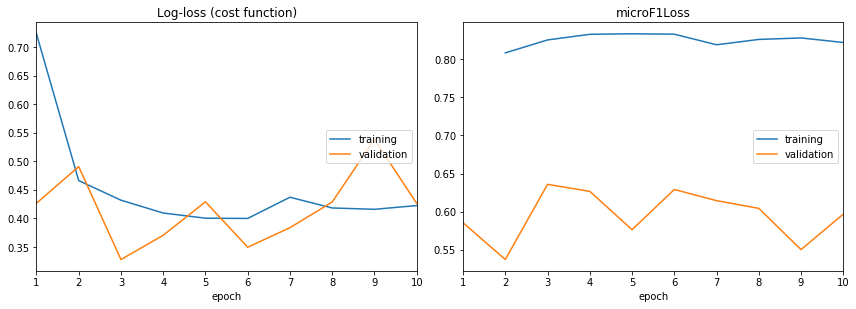

Log-loss (cost function):
training   (min:    0.400, max:    0.723, cur:    0.422)
validation (min:    0.328, max:    0.538, cur:    0.426)

microF1Loss:
training   (min:    0.808, max:    0.833, cur:    0.822)
validation (min:    0.537, max:    0.636, cur:    0.597)


In [275]:
from livelossplot.keras import PlotLossesCallback

class_weight = {0: len(labels)/np.sum(np.argmax(labels, axis=1)!=1),
                1: len(labels)/np.sum(np.argmax(labels, axis=1)==1)}

model = buildSingleModel(embeddingMatrix, hidDim=128, learnEmbs=False)
model.fit(train_all, labels, batch_size=128, epochs=10,
          callbacks=[PlotLossesCallback()], verbose=0,
          validation_data=(test_all, testLabels))

In [465]:
def construct_meta_features(data):
    # Compute emoji-based features
    emojis = ['😂', '😭', '😞', '😢', '😁', '😅', '😍',
              '😀', '😃', '😡', '😄', '😆', '😒', '😊',
              '😌', '😠', '😤', '🙂', '😺', '😫', '😩',
              '😹', '😜', '👍', '😘', '😸', '😉', '😽',
              '😻', '😏', '💔', '😝', '😑', '🙁', '😾',
              '😿', '😬', '❤', '😋', '🙄', '😔', '🙀',
              '😎', '👎', '😦', '😧', '❤️', '😛', '😶',
              '😐', '👌', '🤔','😇', '😨', '😯', '😳',
              '☹️', '💋', '👋', '😪', '😥', '💕', '😱',
              '🙈', '😟', '🙏', '✌', '😖', '😣', '😮',
              '🤗', '😓', '😷', '☹', '💞', '🏻', '🙌',
              '💐', '🙊', '😰', '☺', '😴', '🖕', '♥', '😕',
              '😈', '💗', '♡', '👀', '👊', '‑c', ' 8‑d', ' ‑d',
              '👻', '：）', '.', '?', '!', ',', '-', '・', "'-'",
              '\U0001f923','・ω・', '\U000fe339', ' ‑c']
    happy_words = ['happy', 'lol', 'haha', 'enjoy', 'cool', 'glad',
                   'smile', 'nice', 'funny', 'wow', 'good', 'best',
                   'party', 'baby', 'sweet', 'joke', 'glad', 'perfect',
                   'fantastic', 'excite', 'cute', 'enjoy', 'omg']
    angry_words = ['angry', 'fuck', 'hell', 'shut up', 'bad', 'rude',
                  'block', 'stupid', 'piss', 'lame', "don't", 'mean',
                  'irritat', 'hate', 'ignore', 'get lost', 'reply',
                  'fool', 'regret', 'dumb', 'cheat', 'whore', 'disgust']
    sad_words   = ['sad', 'sorry', 'miss', 'alone', 'lonely', 'cry',
                   'disappointed', 'not', 'no', 'not happy', 'crazy',
                   'stress', 'depress', 'poor', 'care', 'health', 'break up',
                   'breaking up', 'upset', 'forgive', 'left me', 'dump']
    others_words = ['thank you', 'favorite', 'favourite']
    indicator_words = emojis + happy_words + angry_words + sad_words + others_words
    
    word_features = np.zeros((len(data), len(indicator_words)))
    for i, text in enumerate(data):
        for j, word in enumerate(indicator_words):
            useful_text = text.lower()
#             useful_text = " ".join([text.split(' <eos> ')[0], text.split(' <eos> ')[-1]]).lower()
            word_features[i][j] += useful_text.count(word)
    
    # Compute CAPS-based features
    capital_features = np.zeros((len(data), 3))
    for i, text in enumerate(data):
        for word in text.split(' '):
            if word.isupper():
                capital_features[i][0] += 1
        capital_features[i][1] = capital_features[i][0] / (len(text.split(' ')) + 1)
        capital_features[i][2] = sum([len(x) for x in text.split(' ')]) / len(text.split(' '))
    
    # Combine metadata-based features
    metadata_features = np.concatenate((word_features, capital_features), axis=1)
    return metadata_features

In [466]:
metadata_features = construct_meta_features(rawtrainTexts)
print(metadata_features.shape)

(30160, 180)


In [446]:
# Train classifier for metadata-based classification
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score
meta_clf = tree.DecisionTreeClassifier()
meta_clf.fit(metadata_features, np.argmax(labels, axis=1))
getMetrics(meta_clf.predict_proba(metadata_features), labels)

True Positives per class :  [14930.  4063.  5074.  5246.]
False Positives per class :  [787.  12.  44.   4.]
False Negatives per class :  [ 18. 180. 389. 260.]
Class happy : Precision : 0.997, Recall : 0.958, F1 : 0.977
Class sad : Precision : 0.991, Recall : 0.929, F1 : 0.959
Class angry : Precision : 0.999, Recall : 0.953, F1 : 0.975
Ignoring the Others class, Macro Precision : 0.9959, Macro Recall : 0.9464, Macro F1 : 0.9705
Ignoring the Others class, Micro TP : 14383, FP : 60, FN : 829
Accuracy : 0.9719, Micro Precision : 0.9958, Micro Recall : 0.9455, Micro F1 : 0.9700


(0.9719164456233422, 0.99584574, 0.94550353, 0.9700219082279653)

In [447]:
# Test train accuracy with and without emoji-augmentation
# preds = model.predict([train_l, train_m, train_r], batch_size=1024)
preds = model.predict(train_all, batch_size=1024)

In [448]:
preds_augment = meta_clf.predict_proba(metadata_features)

In [276]:
# predictions = model.predict([test_l, test_m, test_r], batch_size=1024)
# predictions = model.predict([test_l, test_r], batch_size=1024)
predictions = model.predict(test_all, batch_size=1024)

In [277]:
# predictions = combined_clf.predict_proba(combined_test_features)

test_meta = construct_meta_features(rawtestTexts)
predictions_meta = meta_clf.predict_proba(test_meta)

In [199]:
# See F1 scores for varying threshold values of max pred value
# print(sorted(predictions[:,1], reverse=True))
consider_indices = np.where(predictions[:,1] >= 0.8)[0]
getMetrics(predictions[consider_indices], testLabels[consider_indices])
print()
consider_indices = np.where(predictions[:,2] >= 0.6)[0]
getMetrics(predictions[consider_indices], testLabels[consider_indices])
print()
consider_indices = np.where(predictions[:,3] >= 0.9)[0]
getMetrics(predictions[consider_indices], testLabels[consider_indices])

True Positives per class :  [ 0. 62.  0.  0.]
False Positives per class :  [ 0. 40.  0.  0.]
False Negatives per class :  [39.  0.  1.  0.]
Class happy : Precision : 0.608, Recall : 1.000, F1 : 0.756
Class sad : Precision : nan, Recall : 0.000, F1 : 0.000
Class angry : Precision : nan, Recall : nan, F1 : 0.000
Ignoring the Others class, Macro Precision : nan, Macro Recall : nan, Macro F1 : 0.0000
Ignoring the Others class, Micro TP : 62, FP : 40, FN : 1
Accuracy : 0.6078, Micro Precision : 0.6078, Micro Recall : 0.9841, Micro F1 : 0.7515

True Positives per class :  [ 0.  0. 72.  0.]
False Positives per class :  [ 0.  0. 30.  0.]
False Negatives per class :  [28.  1.  0.  1.]
Class happy : Precision : nan, Recall : 0.000, F1 : 0.000
Class sad : Precision : 0.706, Recall : 1.000, F1 : 0.828
Class angry : Precision : nan, Recall : 0.000, F1 : 0.000
Ignoring the Others class, Macro Precision : nan, Macro Recall : 0.3333, Macro F1 : 0.0000
Ignoring the Others class, Micro TP : 72, FP : 30,

/home/paragag/persona/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in float_scalars
/home/paragag/persona/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in float_scalars


(0.753968253968254, 0.75396824, 0.96938777, 0.848214281722903)

In [226]:
predictions_handcrafted = []
for i, pred in enumerate(predictions):
    if pred[1] >= 0.8:
        predictions_handcrafted.append([0, 1, 0, 0])
    elif pred[2] >= 0.6:
        predictions_handcrafted.append([0, 0, 1, 0])
    elif pred[3] >= 0.9:
        predictions_handcrafted.append([0, 0, 0, 1])
    else:
#         predictions_handcrafted.append([1, 0, 0, 0])
#         predictions_handcrafted.append(pred)
#         print(np.argmax(predictions_meta[i]), np.argmax(pred))
        predictions_handcrafted.append(predictions_meta[i])

predictions_handcrafted = np.array(predictions_handcrafted)
getMetrics(predictions_handcrafted, testLabels)

True Positives per class :  [1719.  101.   96.  118.]
False Positives per class :  [ 81. 208. 241. 191.]
False Negatives per class :  [619.  41.  29.  32.]
Class happy : Precision : 0.327, Recall : 0.711, F1 : 0.448
Class sad : Precision : 0.285, Recall : 0.768, F1 : 0.416
Class angry : Precision : 0.382, Recall : 0.787, F1 : 0.514
Ignoring the Others class, Macro Precision : 0.3312, Macro Recall : 0.7553, Macro F1 : 0.4605
Ignoring the Others class, Micro TP : 315, FP : 640, FN : 102
Accuracy : 0.7383, Micro Precision : 0.3298, Micro Recall : 0.7554, Micro F1 : 0.4592


(0.7382940108892923, 0.32984293, 0.7553957, 0.4591836465880487)

In [463]:
getMetrics(predictions, testLabels)
print()
predictions_sly = np.copy(predictions)
for i in range(len(predictions_sly)):
    if predictions_sly[i][0] >= 0.2:
        predictions_sly[i] = [1, 0, 0, 0]
    elif predictions_sly[i][2] >= 0.3:
        predictions_sly[i] = [0, 0, 1, 0]
alpha = 0.7
getMetrics(predictions_sly, testLabels)
print()
getMetrics(alpha * predictions_sly + (1-alpha) * predictions_meta, testLabels)

True Positives per class :  [2029.   95.   98.  130.]
False Positives per class :  [ 67. 138. 103.  95.]
False Negatives per class :  [309.  47.  27.  20.]
Class happy : Precision : 0.408, Recall : 0.669, F1 : 0.507
Class sad : Precision : 0.488, Recall : 0.784, F1 : 0.601
Class angry : Precision : 0.578, Recall : 0.867, F1 : 0.693
Ignoring the Others class, Macro Precision : 0.4910, Macro Recall : 0.7732, Macro F1 : 0.6006
Ignoring the Others class, Micro TP : 323, FP : 336, FN : 94
Accuracy : 0.8537, Micro Precision : 0.4901, Micro Recall : 0.7746, Micro F1 : 0.6004

True Positives per class :  [2217.   72.   94.  113.]
False Positives per class :  [124.  41.  49.  45.]
False Negatives per class :  [121.  70.  31.  37.]
Class happy : Precision : 0.637, Recall : 0.507, F1 : 0.565
Class sad : Precision : 0.657, Recall : 0.752, F1 : 0.701
Class angry : Precision : 0.715, Recall : 0.753, F1 : 0.734
Ignoring the Others class, Macro Precision : 0.6699, Macro Recall : 0.6708, Macro F1 : 0.6

(0.9067150635208712, 0.67718446, 0.66906476, 0.6731001249880632)

In [453]:
# predictions  = 0.5 * predictions + 0.5 * predictions_meta
with io.open("./parag_preds.txt", "w", encoding="utf8") as fout:
    for pred in predictions:
        fout.write('\t'.join([str(x) for x in pred]) + "\n")

In [436]:
predictions_towrite = (predictions).argmax(axis=1)
# predictions_towrite = (alpha * predictions_sly + (1-alpha) * predictions_meta).argmax(axis=1)

with io.open(solutionPath, "w", encoding="utf8") as fout:
    fout.write('\t'.join(["id", "turn1", "turn2", "turn3", "label"]) + '\n')        
    with io.open(testDataPath, encoding="utf8") as fin:
        fin.readline()
        for lineNum, line in enumerate(fin):
            fout.write('\t'.join(line.strip().split('\t')[:4]) + '\t')
            fout.write(label2emotion[predictions_towrite[lineNum]] + '\n')
print("Completed")

Completed


In [ ]:
avg_len = [0, 0, 0]
set_len = [15, 15, 15]
for x in trainTexts:
    parts = x.split(' <eos> ')
    for j in range(3):
        if len(parts[j].split(' ')) <= set_len[j]:
            avg_len[j] += 1
print([avg_len[i]/len(trainTexts) for i in range(3)])